In [1]:
import numpy as np
import cv2
import os
from os import listdir
from os.path import isfile, isdir, join
from matplotlib import pyplot as plt

os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
import keras
from keras.layers import Input, Dense, Conv1D, Flatten, BatchNormalization
from keras.layers.merge import concatenate
from keras import Model

Using plaidml.keras.backend backend.


In [2]:
class DescriptorNet(keras.Model):
    def __init__(self):
        super(DescriptorNet, self).__init__()
        # Input 1 ground truth descriptors
        self.convA1 = Conv1D(1000, kernel_size=1, activation='relu')
        self.convA2 = Conv1D(500, kernel_size=1, activation='relu')
        self.convA3 = Conv1D(250, kernel_size=1, activation='relu')
        self.convA4 = Conv1D(125, kernel_size=1, activation='relu')
        self.convA5 = Conv1D(64, kernel_size=1, activation='relu')
        self.convA6 = Conv1D(32, kernel_size=1, activation='relu')
        self.convA7 = Conv1D(4, kernel_size=1, activation='relu')
        self.batchNormA1 = BatchNormalization()
        self.batchNormA2 = BatchNormalization()
        self.batchNormA3 = BatchNormalization()
        self.flatten1 = Flatten()
        
        # Input 2, NIR descriptors
        self.convB1 = Conv1D(1000, kernel_size=1, activation='relu')
        self.convB2 = Conv1D(500, kernel_size=1, activation='relu')
        self.convB3 = Conv1D(250, kernel_size=1, activation='relu')
        self.convB4 = Conv1D(125, kernel_size=1, activation='relu')
        self.convB5 = Conv1D(64, kernel_size=1, activation='relu')
        self.convB6 = Conv1D(32, kernel_size=1, activation='relu')
        self.convB7 = Conv1D(4, kernel_size=1, activation='relu')
        self.batchNormB1 = BatchNormalization()
        self.batchNormB2 = BatchNormalization()
        self.batchNormB3 = BatchNormalization()
        self.flatten2 = Flatten()
        
        # Merge
        self.dense1 = Dense(1024 , activation='relu')
        
        # Output 1, Rotation & skewness matrix (h11, h22)
        self.denseX1 = Dense(512 , activation='relu')
        self.output1 = Dense(2 , activation='tanh', name='rotation_output1')
        
        # Output 2, Rotation & skewness matrix (h12, h21)
        self.denseY1 = Dense(512 , activation='relu')
        self.output2 = Dense(2 , activation='tanh', name='rotation_output2')
        
        # Output 3, Translation matrix
        self.denseZ1 = Dense(512 , activation='relu')
        self.output3 = Dense(2 , activation='linear', name='translation_output')
        
    def call(self, inputs):
        x = inputs[0]
        
        x = self.convA1(x)
        x = self.convA2(x)
        #x = self.batchNormA1(x)
        x = self.convA3(x)
        x = self.convA4(x)
        #x = self.batchNormA2(x)
        x = self.convA5(x)
        x = self.convA6(x)
        x = self.convA7(x)
        #x = self.batchNormA3(x)
        x = self.flatten1(x)
        
        y = inputs[1]
        y = self.convB1(y)
        y = self.convB2(y)
        #y = self.batchNormB1(y)
        y = self.convB3(y)
        y = self.convB4(y)
        #y = self.batchNormB2(y)
        y = self.convB5(y)
        y = self.convB6(y)
        y = self.convB7(y)
        #y = self.batchNormB3(y)
        y = self.flatten2(y)
        
        neck = concatenate([x, y])
        neck = self.dense1(neck)
        
        z1 = self.denseX1(neck)
        z1 = self.output1(z1)
        z2 = self.denseY1(neck)
        z2 = self.output2(z2)
        z3 = self.denseZ1(neck)
        z3 = self.output3(z3)
        
        return [z1, z2, z3]
    
    def model(self):
        x = Input(shape=(128, 2000))
        y = Input(shape=(128, 2000))
        return Model(inputs=[x, y], outputs=self.call([x, y]))
        

In [3]:
model = DescriptorNet()
model.model().summary()

INFO:plaidml:Opening device "opencl_amd_ellesmere.0"


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 2000)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 128, 2000)    0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 128, 1000)    2001000     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_8 (Conv1D)               (None, 128, 1000)    2001000     input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (

In [4]:
H = np.load('HomoMat.npy')
GroundDes = np.load('GroundDes.npy')
NirDes = np.load('NirDes.npy')


train_x = [GroundDes, NirDes]
train_y = [np.array([H[:, 0, 0], H[:, 1, 1]]).transpose(), 
           np.array([H[:, 1, 0], H[:, 0, 1]]).transpose(),
           H[:, :, 2]
          ]

# train_y = np.delete(train_y, -1, axis=1)
print('X.shape')
print(train_x[0].shape)
print(train_x[1].shape)
print('Y.shape')
print(train_y[0].shape)
print(train_y[1].shape)
print(train_y[2].shape)

X.shape
(137, 128, 2000)
(137, 128, 2000)
Y.shape
(137, 2)
(137, 2)
(137, 2)


In [18]:
opt = keras.optimizers.Adam(lr=0.00001)
model.compile(loss='mse', optimizer=opt, loss_weights=[0.00001, 1.0, 0.00001])
history = model.fit(train_x, train_y, batch_size=32, epochs=500, validation_split=0.0)


Epoch 1/500
137/137 [==============================] - 27s 193ms/step - loss: 0.0078 - output_1_loss: 3.4034e-05 - output_2_loss: 0.0078 - output_3_loss: 2.5114
Epoch 2/500
137/137 [==============================] - 1s 5ms/step - loss: 0.0039 - output_1_loss: 3.4027e-05 - output_2_loss: 0.0039 - output_3_loss: 2.8147
Epoch 3/500
137/137 [==============================] - 1s 5ms/step - loss: 0.0022 - output_1_loss: 3.4021e-05 - output_2_loss: 0.0022 - output_3_loss: 3.4078
Epoch 4/500
137/137 [==============================] - 1s 5ms/step - loss: 0.0016 - output_1_loss: 3.4014e-05 - output_2_loss: 0.0016 - output_3_loss: 3.9484
Epoch 5/500
137/137 [==============================] - 1s 5ms/step - loss: 0.0012 - output_1_loss: 3.4009e-05 - output_2_loss: 0.0012 - output_3_loss: 4.1699
Epoch 6/500
137/137 [==============================] - 1s 5ms/step - loss: 8.2998e-04 - output_1_loss: 3.4005e-05 - output_2_loss: 7.8901e-04 - output_3_loss: 4.0974
Epoch 7/500
137/137 [====================

137/137 [==============================] - 1s 5ms/step - loss: 2.3025e-05 - output_1_loss: 3.3999e-05 - output_2_loss: 1.4675e-08 - output_3_loss: 2.3010
Epoch 51/500
137/137 [==============================] - 1s 5ms/step - loss: 2.2989e-05 - output_1_loss: 3.3999e-05 - output_2_loss: 1.8468e-08 - output_3_loss: 2.2970
Epoch 52/500
137/137 [==============================] - 1s 5ms/step - loss: 2.2925e-05 - output_1_loss: 3.3999e-05 - output_2_loss: 2.1683e-08 - output_3_loss: 2.2903
Epoch 53/500
137/137 [==============================] - 1s 5ms/step - loss: 2.2913e-05 - output_1_loss: 3.3999e-05 - output_2_loss: 2.2441e-08 - output_3_loss: 2.2891
Epoch 54/500
137/137 [==============================] - 1s 5ms/step - loss: 2.2883e-05 - output_1_loss: 3.3999e-05 - output_2_loss: 1.5691e-08 - output_3_loss: 2.2867
Epoch 55/500
137/137 [==============================] - 1s 5ms/step - loss: 2.2844e-05 - output_1_loss: 3.3999e-05 - output_2_loss: 2.0274e-08 - output_3_loss: 2.2823
Epoch 56/50

137/137 [==============================] - 1s 5ms/step - loss: 2.1616e-05 - output_1_loss: 3.3998e-05 - output_2_loss: 2.9156e-08 - output_3_loss: 2.1586
Epoch 100/500
137/137 [==============================] - 1s 5ms/step - loss: 2.1588e-05 - output_1_loss: 3.3998e-05 - output_2_loss: 5.5964e-08 - output_3_loss: 2.1531
Epoch 101/500
137/137 [==============================] - 1s 5ms/step - loss: 2.1599e-05 - output_1_loss: 3.3998e-05 - output_2_loss: 7.7069e-08 - output_3_loss: 2.1522
Epoch 102/500
137/137 [==============================] - 1s 5ms/step - loss: 2.1569e-05 - output_1_loss: 3.3998e-05 - output_2_loss: 6.8206e-08 - output_3_loss: 2.1500
Epoch 103/500
137/137 [==============================] - 1s 5ms/step - loss: 2.1471e-05 - output_1_loss: 3.3998e-05 - output_2_loss: 3.1483e-08 - output_3_loss: 2.1439
Epoch 104/500
137/137 [==============================] - 1s 5ms/step - loss: 2.1405e-05 - output_1_loss: 3.3998e-05 - output_2_loss: 2.0380e-08 - output_3_loss: 2.1384
Epoch 

137/137 [==============================] - 1s 5ms/step - loss: 3.1591e-05 - output_1_loss: 3.3981e-05 - output_2_loss: 1.1618e-05 - output_3_loss: 1.9973
Epoch 148/500
137/137 [==============================] - 1s 5ms/step - loss: 3.0781e-05 - output_1_loss: 3.3980e-05 - output_2_loss: 1.0881e-05 - output_3_loss: 1.9900
Epoch 149/500
137/137 [==============================] - 1s 5ms/step - loss: 4.4437e-05 - output_1_loss: 3.3980e-05 - output_2_loss: 2.4598e-05 - output_3_loss: 1.9838
Epoch 150/500
137/137 [==============================] - 1s 5ms/step - loss: 4.5755e-05 - output_1_loss: 3.3980e-05 - output_2_loss: 2.5940e-05 - output_3_loss: 1.9814
Epoch 151/500
137/137 [==============================] - 1s 5ms/step - loss: 4.0335e-05 - output_1_loss: 3.3980e-05 - output_2_loss: 2.0537e-05 - output_3_loss: 1.9798
Epoch 152/500
137/137 [==============================] - 1s 5ms/step - loss: 3.6277e-05 - output_1_loss: 3.3979e-05 - output_2_loss: 1.6477e-05 - output_3_loss: 1.9800
Epoch 

137/137 [==============================] - 1s 5ms/step - loss: 2.0707e-05 - output_1_loss: 3.3975e-05 - output_2_loss: 2.1940e-06 - output_3_loss: 1.8512
Epoch 196/500
137/137 [==============================] - 1s 5ms/step - loss: 2.1058e-05 - output_1_loss: 3.3975e-05 - output_2_loss: 2.5412e-06 - output_3_loss: 1.8517
Epoch 197/500
137/137 [==============================] - 1s 5ms/step - loss: 2.0304e-05 - output_1_loss: 3.3975e-05 - output_2_loss: 1.8546e-06 - output_3_loss: 1.8449
Epoch 198/500
137/137 [==============================] - 1s 5ms/step - loss: 1.9746e-05 - output_1_loss: 3.3975e-05 - output_2_loss: 1.3350e-06 - output_3_loss: 1.8411
Epoch 199/500
137/137 [==============================] - 1s 5ms/step - loss: 1.9558e-05 - output_1_loss: 3.3975e-05 - output_2_loss: 1.1384e-06 - output_3_loss: 1.8419
Epoch 200/500
137/137 [==============================] - 1s 5ms/step - loss: 1.9664e-05 - output_1_loss: 3.3975e-05 - output_2_loss: 1.2561e-06 - output_3_loss: 1.8407
Epoch 

137/137 [==============================] - 1s 5ms/step - loss: 3.4916e-05 - output_1_loss: 3.3965e-05 - output_2_loss: 1.7674e-05 - output_3_loss: 1.7241
Epoch 244/500
137/137 [==============================] - 1s 5ms/step - loss: 3.0265e-05 - output_1_loss: 3.3965e-05 - output_2_loss: 1.3043e-05 - output_3_loss: 1.7222
Epoch 245/500
137/137 [==============================] - 1s 5ms/step - loss: 2.9490e-05 - output_1_loss: 3.3965e-05 - output_2_loss: 1.2256e-05 - output_3_loss: 1.7234
Epoch 246/500
137/137 [==============================] - 1s 4ms/step - loss: 5.5540e-05 - output_1_loss: 3.3965e-05 - output_2_loss: 3.8274e-05 - output_3_loss: 1.7265
Epoch 247/500
137/137 [==============================] - 1s 4ms/step - loss: 5.2186e-05 - output_1_loss: 3.3964e-05 - output_2_loss: 3.4991e-05 - output_3_loss: 1.7194
Epoch 248/500
137/137 [==============================] - 1s 4ms/step - loss: 1.3348e-04 - output_1_loss: 3.3962e-05 - output_2_loss: 1.1639e-04 - output_3_loss: 1.7098
Epoch 

137/137 [==============================] - 1s 4ms/step - loss: 1.6569e-05 - output_1_loss: 3.3888e-05 - output_2_loss: 3.6697e-07 - output_3_loss: 1.6202
Epoch 292/500
137/137 [==============================] - 1s 4ms/step - loss: 1.6682e-05 - output_1_loss: 3.3888e-05 - output_2_loss: 5.1416e-07 - output_3_loss: 1.6167
Epoch 293/500
137/137 [==============================] - 1s 5ms/step - loss: 1.6680e-05 - output_1_loss: 3.3888e-05 - output_2_loss: 5.4111e-07 - output_3_loss: 1.6139
Epoch 294/500
137/137 [==============================] - 1s 4ms/step - loss: 1.6423e-05 - output_1_loss: 3.3887e-05 - output_2_loss: 2.9029e-07 - output_3_loss: 1.6132
Epoch 295/500
137/137 [==============================] - 1s 5ms/step - loss: 1.6397e-05 - output_1_loss: 3.3887e-05 - output_2_loss: 2.8035e-07 - output_3_loss: 1.6116
Epoch 296/500
137/137 [==============================] - 1s 4ms/step - loss: 1.6477e-05 - output_1_loss: 3.3887e-05 - output_2_loss: 3.8127e-07 - output_3_loss: 1.6095
Epoch 

137/137 [==============================] - 1s 5ms/step - loss: 1.5608e-05 - output_1_loss: 3.3884e-05 - output_2_loss: 3.6708e-07 - output_3_loss: 1.5241
Epoch 340/500
137/137 [==============================] - 1s 5ms/step - loss: 1.5480e-05 - output_1_loss: 3.3884e-05 - output_2_loss: 2.1242e-07 - output_3_loss: 1.5267
Epoch 341/500
137/137 [==============================] - 1s 5ms/step - loss: 1.5444e-05 - output_1_loss: 3.3884e-05 - output_2_loss: 1.9270e-07 - output_3_loss: 1.5251
Epoch 342/500
137/137 [==============================] - 1s 5ms/step - loss: 1.5538e-05 - output_1_loss: 3.3884e-05 - output_2_loss: 3.2802e-07 - output_3_loss: 1.5210
Epoch 343/500
137/137 [==============================] - 1s 5ms/step - loss: 1.5331e-05 - output_1_loss: 3.3885e-05 - output_2_loss: 1.5402e-07 - output_3_loss: 1.5176
Epoch 344/500
137/137 [==============================] - 1s 5ms/step - loss: 1.5344e-05 - output_1_loss: 3.3885e-05 - output_2_loss: 1.7830e-07 - output_3_loss: 1.5165
Epoch 

137/137 [==============================] - 1s 4ms/step - loss: 3.2784e-05 - output_1_loss: 3.3866e-05 - output_2_loss: 1.8242e-05 - output_3_loss: 1.4542
Epoch 388/500
137/137 [==============================] - 1s 5ms/step - loss: 4.5245e-05 - output_1_loss: 3.3867e-05 - output_2_loss: 3.0826e-05 - output_3_loss: 1.4419
Epoch 389/500
137/137 [==============================] - 1s 5ms/step - loss: 2.8676e-05 - output_1_loss: 3.3866e-05 - output_2_loss: 1.4222e-05 - output_3_loss: 1.4453
Epoch 390/500
137/137 [==============================] - 1s 5ms/step - loss: 2.5712e-05 - output_1_loss: 3.3865e-05 - output_2_loss: 1.1291e-05 - output_3_loss: 1.4421
Epoch 391/500
137/137 [==============================] - 1s 5ms/step - loss: 3.1291e-05 - output_1_loss: 3.3863e-05 - output_2_loss: 1.6944e-05 - output_3_loss: 1.4347
Epoch 392/500
137/137 [==============================] - 1s 5ms/step - loss: 2.1143e-05 - output_1_loss: 3.3861e-05 - output_2_loss: 6.7375e-06 - output_3_loss: 1.4405
Epoch 

137/137 [==============================] - 1s 4ms/step - loss: 3.7925e-05 - output_1_loss: 3.3811e-05 - output_2_loss: 2.4275e-05 - output_3_loss: 1.3650
Epoch 436/500
137/137 [==============================] - 1s 5ms/step - loss: 3.2651e-05 - output_1_loss: 3.3808e-05 - output_2_loss: 1.8929e-05 - output_3_loss: 1.3721
Epoch 437/500
137/137 [==============================] - 1s 4ms/step - loss: 2.7101e-05 - output_1_loss: 3.3808e-05 - output_2_loss: 1.3458e-05 - output_3_loss: 1.3643
Epoch 438/500
137/137 [==============================] - 1s 5ms/step - loss: 2.9753e-05 - output_1_loss: 3.3808e-05 - output_2_loss: 1.6104e-05 - output_3_loss: 1.3649
Epoch 439/500
137/137 [==============================] - 1s 5ms/step - loss: 3.0017e-05 - output_1_loss: 3.3808e-05 - output_2_loss: 1.6385e-05 - output_3_loss: 1.3632
Epoch 440/500
137/137 [==============================] - 1s 5ms/step - loss: 2.9540e-05 - output_1_loss: 3.3807e-05 - output_2_loss: 1.5924e-05 - output_3_loss: 1.3616
Epoch 

137/137 [==============================] - 1s 4ms/step - loss: 4.5080e-05 - output_1_loss: 3.3550e-05 - output_2_loss: 3.1977e-05 - output_3_loss: 1.3103
Epoch 484/500
137/137 [==============================] - 1s 4ms/step - loss: 6.9586e-05 - output_1_loss: 3.3548e-05 - output_2_loss: 5.6506e-05 - output_3_loss: 1.3080
Epoch 485/500
137/137 [==============================] - 1s 4ms/step - loss: 6.2956e-05 - output_1_loss: 3.3542e-05 - output_2_loss: 4.9898e-05 - output_3_loss: 1.3058
Epoch 486/500
137/137 [==============================] - 1s 5ms/step - loss: 4.5464e-05 - output_1_loss: 3.3535e-05 - output_2_loss: 3.2355e-05 - output_3_loss: 1.3108
Epoch 487/500
137/137 [==============================] - 1s 5ms/step - loss: 5.3270e-05 - output_1_loss: 3.3532e-05 - output_2_loss: 4.0235e-05 - output_3_loss: 1.3034
Epoch 488/500
137/137 [==============================] - 1s 5ms/step - loss: 4.1457e-05 - output_1_loss: 3.3527e-05 - output_2_loss: 2.8450e-05 - output_3_loss: 1.3007
Epoch 

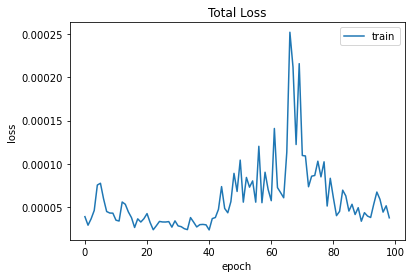

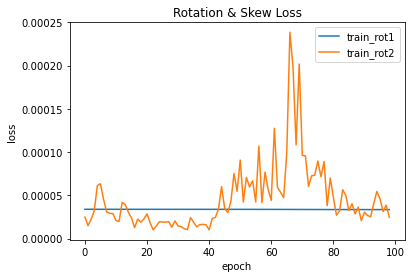

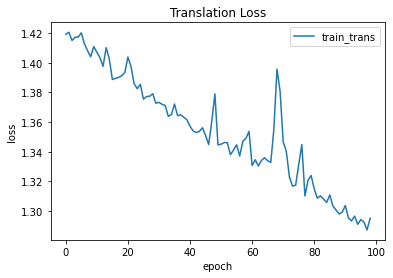

In [22]:
plt.plot(history.history['loss'][-100:-1])
#plt.plot(history.history['val_loss'][-100:-1])
plt.title('Total Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

plt.figure()
plt.plot(history.history['output_1_loss'][-100:-1])
plt.plot(history.history['output_2_loss'][-100:-1])
#plt.plot(history.history['val_output_1_loss'][-100:-1])
#plt.plot(history.history['val_output_2_loss'][-100:-1])
plt.title('Rotation & Skew Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_rot1', 'train_rot2', 'test_rot1', 'test_rot2'])
plt.show()

plt.figure()
plt.plot(history.history['output_3_loss'][-100:-1])
#plt.plot(history.history['val_output_3_loss'][-100:-1])
plt.title('Translation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_trans', 'test_trans'])
plt.show()

In [35]:
def SIFT(img):
    siftDetector= cv2.xfeatures2d.SIFT_create(2000)
    kp, des = siftDetector.detectAndCompute(img, None)
    return kp, des

name = '0110'

img1 = cv2.imread('C:/Users/tmyda/Documents/UAV_color/{name}/IMG_{name}_2.tif'.format(name=name), cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('C:/Users/tmyda/Documents/UAV_color/{name}/IMG_{name}_4.tif'.format(name=name), cv2.IMREAD_GRAYSCALE)
_, des1 = SIFT(img1)
_, des2 = SIFT(img2)
des1 = np.expand_dims(des1.transpose(), axis=0) / 512
des2 = np.expand_dims(des2.transpose(), axis=0) / 512

p = model.predict([des1, des2])
p = np.array(
    [[p[0].squeeze()[0], p[1].squeeze()[0], p[2].squeeze()[0]],
     [p[1].squeeze()[1], p[0].squeeze()[1], p[2].squeeze()[1]]])
h = H[1]

In [36]:
print(p)
print()
print(h)

head = cv2.imread('C:/Users/tmyda/Documents/UAV_color/{name}/IMG_{name}_2.tif'.format(name=name), cv2.IMREAD_GRAYSCALE)
img = np.zeros((head.shape[0], head.shape[1], 3), dtype='uint8')
img[:, :, 0] = head
img[:, :, 1] = 0 #cv2.imread('C:/Users/tmyda/Documents/UAV_color/{name}/IMG_{name}_3toIMG_{name}_2_registered.tif'.format(name=name), cv2.IMREAD_GRAYSCALE)
img[:, :, 2] = cv2.imread('C:/Users/tmyda/Documents/UAV_color/{name}/IMG_{name}_4.tif'.format(name=name), cv2.IMREAD_GRAYSCALE)

height, width, channels = img.shape
img[:,:,2] = cv2.warpAffine(img[:,:,2], p, (width, height))
cv2.imshow('Reg', img)

img[:, :, 2] = cv2.imread('C:/Users/tmyda/Documents/UAV_color/{name}/IMG_{name}_4.tif'.format(name=name), cv2.IMREAD_GRAYSCALE)
img[:,:,2] = cv2.warpAffine(img[:,:,2], h, (width, height))
cv2.imshow('Reg_H', img)

cv2.waitKey(0)
cv2.destroyAllWindows()

[[ 9.9997425e-01  8.4222011e-02  3.2763554e+01]
 [-2.9653588e-02  9.9996495e-01 -3.4350689e+01]]

[[ 9.93996270e-01  2.22479887e-04  3.32327106e+01]
 [-2.22479887e-04  9.93996270e-01 -3.45610212e+01]]


In [45]:
model.save_weights('./weights/DescriptorNet_weights_202018Aug.h5')